# Processing Data From Scratch

**... with Bowman (2018) data**.

In this tutorial, we will go through an _entire_ processing of a subset of the data going into the [Bowman et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018Natur.555...67B/abstract) Nature paper. The point here is _not_ to reproduce the exact results (note: there is an [effort to do this](https://github.com/edges-collab/edges-bowman2018-pipeline) that you can follow). It is rather to show the various steps involved from a _users_ perspective, and justify some of those choices. 

The point is also _not_ to provide a full mathematical description and justification of all the procedures. That will be done elsewhere (pending...). The point is to give you enough of a description that you have a high level idea of what's going on, and then also to show you _how_ to use the code to achieve it. We will also focus a little on the expected _workflow_ -- running a processing step, visualising the results, and iterating.

## High-level overview

Before getting into any actual calculations, let's go over what the purpose of `edges-analysis` is, and what it essentially does.

The purpose of the `analysis` part of `edges-analysis` is to take existing raw spectrum data, measured in the field, and process it down to a set of averaged spectra, which can subsequently be fit with some cosmological and foreground model(s) using [`edges-estimate`](https://github.com/edges-collab/edges-estimate). 

There are three main aspects to this processing:

1. Calibration -- applying a linear transformation to _each_ recorded spectrum to convert it from a set of recorded powers to a physical temperature.
2. Filtering -- the process of identifying and flagging _bad_ data (whether due to unstable instrument, environmental conditions, or RFI).
3. Averaging/Integrating -- the process of combining different recorded spectra in a consistent way to improve the signal-to-noise.

One thing to note is that the entire process is _almost_ linear. That is, if we were to apply a different calibration, then do all the filtering and averaging, then invert the initial calibration and apply a different one, it would be _almost_ the same as having just initially applied the different calibration. It is only _almost_ the same because the identification of bad data in the filtering step can rely on the calibrated temperature to some degree.

Though there are three aspects, these are not standalone "steps" in their own right, as if we could just do "calibrate" then "filter" then "average". For one, each aspect has multiple ways of performing it, eg. in "calibration" we need to do the lab-based gain calibration, but also need to correct for losses and the beam chromaticity. Likewise, in "filtering" we can filter on total recorded power, RFI, humidity, etc.

Furthermore, while the calibration routines are all typically applied first, it is generally useful to alternate between filtering and averaging: filter some, average a little more to expose more bad data, filter some more, ... etc. Nevertheless, a lot of the kinds of filtering are most useful before any averaging is done (i.e. on the raw calibrated spectra) -- eg. filtering out high humidity, or filtering on the position of the sun/moon. 

So, given all that, here's the general process as a list of steps:

1. Calibrate, including:
  * Lab-based gain calibration (requiring calibration solutions to be determined elsewhere)
  * Loss corrections from the balun, ground and antenna.
  * Beam chromaticity correction
2. Initial filtering, including:
  * Filtering entire spectra based on auxiliary data (sun/moon/humidity/temperature)
  * Filtering entire spectra based on a prior of total measured power
  * RFI filtering
  * Filtering entire spectra based on the RMS of low-order fits
3. Average each night's spectra into **small, regular** bins of LST/GHA.
  * At the same time, collect all the nights together into one array, shape `(nights, gha, frequency)`.
  * Then do another round of RFI filtering on the averaged data!
4. Average over the nights
  * Leaving an array of shape `(gha, frequency)`.
  * Filter RFI again!
5. Successively average within larger GHA bins
  * Wise to do this a little at a time, doing more RFI flagging with each integration.
  * Final product still `(gha, frequency)`, but with larger GHA bins (as desired).

## Code Overview

So, we have the general steps involved. How does one use `edges-analysis` to achieve this? Before digging into details and actually _performing_ this analysis, let's have a quick high-level look at the code.

### 'Step' Objects

Each of the basic steps above are encoded as [classes/objects](https://edges-analysis.readthedocs.io/en/latest/reference/_autosummary/edges_analysis.analysis.levels.html#module-edges_analysis.analysis.levels) within `edges-analysis`. These objects all have a very similar interface, and have a few cool features:

* They store all the parameters that go into doing the processing, so that you can go back and reproduce it any time.
* They have a `write()` method that writes down all the data into a HDF5 file with a nice structure that is also able to be easily read by the same object.
* They know about one another -- you can `promote()` one set of data to the next step.
* If you write each step to file, the steps further down the chain know who their parents are, and can go and dynamically look up data associated with the parents.
* Thus, *if you write each step to file*, in principle the final step has *all* the information about the whole process available, including *every parameter* used to define it. 
* There is a Command-Line Interface (CLI) that intelligently writes each step to file for you, using a self-consistent file layout.

To be clear, the available steps (in order) are:

1. [CalibratedData](https://edges-analysis.readthedocs.io/en/latest/reference/_autosummary/edges_analysis.analysis.levels.CalibratedData.html)
1. [FilteredData](https://edges-analysis.readthedocs.io/en/latest/reference/_autosummary/edges_analysis.analysis.levels.FilteredData.html)
1. [ModelData](https://edges-analysis.readthedocs.io/en/latest/reference/_autosummary/edges_analysis.analysis.levels.ModelData.html)
1. [CombinedData](https://edges-analysis.readthedocs.io/en/latest/reference/_autosummary/edges_analysis.analysis.levels.CombinedData.html)
1. [DayAverageData](https://edges-analysis.readthedocs.io/en/latest/reference/_autosummary/edges_analysis.analysis.levels.DayAverageData.html)
1. [BinnedData](https://edges-analysis.readthedocs.io/en/latest/reference/_autosummary/edges_analysis.analysis.levels.BinnedData.html)

There is an extra step here: the `ModelData`. As it turns out, all the averaging we do relies on having some fiducial model of each spectrum, so as to make an [unbiased average](http://loco.lab.asu.edu/wp-content/uploads/2020/10/averaging_with_weights.pdf) in the presence of non-uniform weights. So, we fit a model to each un-averaged spectrum at the beginning, and carry through those models and their residuals to the following steps.

Note also that _every_ step has the opportunity to perform RFI filtering (not just `FilteredData`). 

In addition to these basic step objects, some of the steps require external input, like beam and sky models. There are classes for these in their respective modules, and we will refer to them as they come up.

### General Workflow

In general, the workflow for the processing is as follows:

1. Write a YAML settings file defining the inputs to a particular step
1. Run the CLI for that step, inputting files from the previous step (or raw spectra if its the first step), and using the YAML settings.
1. Open up the written file in a notebook/python script with the `read_step` function, and make some plots that show the state of the data. Use this to decide whether to rerun the previous step again with different parameters (or even higher-up steps), and to inform what settings you might want to put on the next step.
1. Repeat from (1) for each step, until you get to the `BinnedData`. 


Note that some of the steps can be run more than once, in particular the `FilteredData` and `BinnedData`. That is you can run multiple filters progressively, and bin progressively. Furthermore, the `FilteredData` step _can_ be skipped entirely (though it is not advisable).

### Compute Intensity

It helps your workflow to understand where the most processing time occurs. Though it is somewhat dependent on your parameter choices, typically the most intensive step is the `FilteredData`, due to the RFI extraction on all individual spectra. If doing RFI extraction on the the `CombinedData`, it is typically the next slowest, followed by `CalibratedData`. The other steps are generally _quite_ fast, and can be rerun quickly to explore different parameters.

## Let's Process Some Data...!

Now that we have an overview, let's dive in and do some data processing, using the workflow of switching between the CLI and the notebook. Fortunately, you can run things on the CLI within a notebook!

The data we will be using is a _subset_ of the data that went into the Nature paper, so that we proceed relatively quickly. Note that this tutorial will assume that we are running on the `enterprise` server on which the raw data is stored. As long as you have the data on your machine, and your paths set correctly, it will work wherever you run it.

All the settings files used here are stored in the [config](https://github.com/edges-collab/edges-analysis/tree/master/docs/demos/config) directory in the Github repo (go ahead and click that link), so you can access them as well.

First, let's import some of the functions that we'll need. Importantly, we'll need the `read_step` function, which is able to read any file defined as one of the analysis steps:

In [140]:
from edges_analysis import read_step

%matplotlib inline
from copy import deepcopy

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setting Up

Before we dive into the actual processing, let's review our overall setup. Since many files are required to do a calibration -- the raw input spectra, the $S_{11}$ measurements of the antenna, auxiliary measurements of humidity etc., beam files, etc., -- `edges-analysis` provides a central location to configure where those different things might be found:

In [2]:
from edges_analysis import cfg

In [3]:
cfg

{'paths': {'antenna': '/home/smurray/edges/Steven/edges-cache/antenna-models',
  'beams': '/home/smurray/edges/Steven/edges-cache/beam-models',
  'field_products': '/home/smurray/edges/Steven/edges-cache/level-cache',
  'lab_products': '/home/smurray/edges/Steven/edges-cache/calibration-cache',
  'raw_field_data': '/data5/edges/data/2014_February_Boolardy',
  'raw_lab_data': '/data4/edges/data/CalibrationObservations',
  'sky_models': '/home/smurray/data4/edges-sky-models/'}}

Changing any of these paths will change the global behaviour of the package. You can also _write_ this config to disk to make that change permanent!

In [4]:
cfg.write()

Importantly, throughout you will see that some input paths are prefixed by `:`. This is a context-aware identifier that points to the _default location_ of a given kind of input, according to the configuration. Eg. passing a beam model path in any function as `:/my_beam.feko` will be interpreted as `cfg['paths']['beams'] / my_beam.feko`.

### Calibration

Let's first look at our settings:

In [5]:
!cat config/calibrate.yml

band: low
f_low: 50
f_high: 100
calfile: /data4/smurray/cal_file_Rcv01_2015_09.h5
s11_path: /data5/edges/data/S11_antenna/low_band/20160830_a/s11
balun_correction: true
antenna_correction: false
ground_correction: ':'
beam_file: /home/nmahesh/edges-beams/low/beam_factors/feko_Haslam408_ref70.00_22f61e7c4b66d33e811dc6825b04001a.h5


The first question is: how do you know what parameters are available, and what they mean? The answer is to look at the input parameters to the `promote` method of the relevant class -- in this case, [CalibratedData.promote](https://edges-analysis.readthedocs.io/en/latest/reference/_autosummary/levels/CalibratedData/edges_analysis.analysis.levels.CalibratedData.promote.html). Anything defined there (except the `prev_step` input itself) can be included in the YAML settings.

Now, what are these settings?

We are using `low` band data (specifically, the low-band2 antenna), and we would like to restrict our attention to the 50-100 MHz band (the intrinsic data goes down to 40 MHz and up to 200 MHz, but the quality of the calibration is extremely poor outside this region).

The `calfile` is a bit more tricky -- clearly it points to an external file. This file is a representation of an `edges_cal.Calibration` object, which you must produce yourself prior to running `edges-analysis` (or get it from someone else). In particular, the calibration observation we are using comes from a lab run in September 2015 -- the same calibration used in the Nature Paper results.

The `s11_path` points to a _directory_ of $S_{11}$ measurements taken in the field. In this directory are four files, each of which is required to produce the corrected $S_{11}$ function. In general, the directory may have many more files -- so long as those files follow a reasonable filename convention with the dates they were obtained, the code will find the measurements closest to each measured spectra, and use those to calibrate.

The `balun` and `antenna` corrections are analytic corrections that are built-in to the code. The original NP results did not use an antenna correction, and neither do we here. The `ground` correction however does require an externally-produced model of the ground plane loss. There is no code in `edges-analysis` to create this file, however, a reasonable default for the low-band is included in the code itself, so passing ":" just finds this default file. 

Finally, the `beam_file` points to a file representing a [beams.InterpolatedBeamFactor](https://edges-analysis.readthedocs.io/en/latest/reference/_autosummary/beams/edges_analysis.analysis.beams.InterpolatedBeamFactor.html) object. This also must be created before running the calibration, however code for doing so is included in `edges-analysis`. We do not show how to do it here, but point you to THIS TUTORIAL (coming...).

Finally, we must decide on our input files. We will use days 2016-290 -- 2016-310 (20 days of data). We run the command as following. Note that `-i` gives the input files (and we use the ":" notation to refer to the default location of spectra on `enterprise`). We give `-i` multiple times, and all the files it finds will be processed. Futhermore, each of them has a `*` in it -- a glob wildcard. 

We also give `-l`, which sets the label for these settings, and also is the output directory into which the results will be saved. Finally, we give `-j` to specify the number of processes to use in parallel.

In [10]:
!edges-analysis process calibrate config/calibrate.yml \
  -i :2016/2016_29* -i :2016/2016_30* \
  -l nature-paper-subset \
  -j 20

╔══════════════════════════════════════════════════════════════════════════════╗
║                           edges-analysis calibrate                           ║
╚══════════════════════════════════════════════════════════════════════════════╝
────────────────────────────────── Setting Up ──────────────────────────────────

                                    Settings                                    
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ band               ┃ low                                                     ┃
│ f_low              │ 50                                                      │
│ f_high             │ 100                                                     │
│ calfile            │ /data4/smurray/cal_file_Rcv01_2015_09.h5                │
│ s11_path           │ /data5/edges/data/S11_antenna/low_band/20160830_a/s11   │
│ balun_correction   │ True                                                    │
│ antenna_correction │ Fals

INFO     Time for reading: 0.00 sec.                                            
INFO     Converting time strings to datetimes...                                
INFO     ...  finished in 0.05 sec.                                             
INFO     Getting ancillary weather data...                                      
/data4/smurray/Projects/radio/EOR/Edges/edges-analysis/src/edges_analysis/analysis/levels.py:1552: RankWarning: Polyfit may be poorly conditioned
  switch_state_repeat_num=switch_state_repeat_num,
/data4/smurray/Projects/radio/EOR/Edges/edges-analysis/src/edges_analysis/analysis/levels.py:1552: RankWarning: Polyfit may be poorly conditioned
  switch_state_repeat_num=switch_state_repeat_num,
INFO     Setting up arrays...                                                   
INFO     .... took 0.002516031265258789 sec.                                    
INFO     Took 0.01175689697265625 sec to interpolate auxiliary data.            
INFO     Time for reading: 0.00 sec.   

INFO     Took 0.008279085159301758 sec to interpolate auxiliary data.           
INFO     Took 0.5257954597473145 sec to get lst/gha                             
INFO     ... finished in 4.00 sec.                                              
INFO     Took 0.48622679710388184 sec to get lst/gha                            
 21%|████████▊                                | 3/14 [01:02<04:29, 24.49s/files]INFO     Took 9.269782543182373 sec to get sun/moon coords.                     
INFO     ... finished in 9.79 sec.                                              
INFO     Calibrating data ...                                                   
/data4/smurray/Projects/radio/EOR/Edges/edges-analysis/src/edges_analysis/analysis/levels.py:1552: RankWarning: Polyfit may be poorly conditioned
  switch_state_repeat_num=switch_state_repeat_num,
/data4/smurray/Projects/radio/EOR/Edges/edges-analysis/src/edges_analysis/analysis/levels.py:1552: RankWarning: Polyfit may be poorly conditioned
  switch_s

INFO     ... finished in 3.58 sec.                                              
/data4/smurray/Projects/radio/EOR/Edges/edges-analysis/src/edges_analysis/analysis/levels.py:1552: RankWarning: Polyfit may be poorly conditioned
  switch_state_repeat_num=switch_state_repeat_num,
/data4/smurray/Projects/radio/EOR/Edges/edges-analysis/src/edges_analysis/analysis/levels.py:1552: RankWarning: Polyfit may be poorly conditioned
  switch_state_repeat_num=switch_state_repeat_num,
INFO     ... finished in 3.50 sec.                                              
INFO     ... finished in 3.55 sec.                                              
INFO     ... finished in 3.99 sec.                                              
INFO     ... finished in 4.02 sec.                                              
INFO     ... finished in 5.38 sec.                                              
INFO     ... finished in 3.76 sec.                                              
100%|██████████████████████████████████

Calibrating these 14 files took only about a minute and a half. Note the informative output we received, especially the last line, which tells us where the output is stored. Let's read one of those files:

In [6]:
cal_step = read_step(
    "/home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/2016-290-00.h5"
)

While you can look at the online API docs to see everything we have access to in this object, you can also use interactive help by pressing tab.

A few important things you have access to are the `.spectrum`:

In [7]:
cal_step.spectrum.shape

(2270, 8192)

the ancillary data:

In [8]:
print(list(cal_step.ancillary.keys()))

['adcmax', 'adcmin', 'ambient_hum', 'ambient_temp', 'frontend_temp', 'gha', 'lna_temp', 'lst', 'moon_az', 'moon_el', 'power_percent', 'rack_temp', 'receiver_temp', 'seconds', 'sun_az', 'sun_el', 'temp_set', 'times']


the frequencies:

In [9]:
cal_step.raw_frequencies.shape

(8192,)

and the metadata:

In [10]:
print(cal_step.meta.keys())

dict_keys(['antenna_correction', 'antenna_s11_n_terms', 'balun_correction', 'band', 'beam_file', 'calfile', 'calobs_path', 'configuration', 'cterms', 'day', 'edges_analysis_version', 'edges_io_version', 'f_high', 'f_low', 'freq_max', 'freq_min', 'freq_res', 'ground_correction', 'hour', 'ignore_s11_files', 'leave_progress', 'message', 'n_file_lines', 'nblk', 'nfreq', 'object_name', 'out_file', 'parent_files', 'progress', 'resolution', 's11_file_pattern', 's11_files', 's11_path', 'switch_state_dir', 'switch_state_repeat_num', 'temperature', 'thermlog_file', 'weather_file', 'write_time', 'wterms', 'xrfi_pipe', 'year'])


Perhaps most important are various plotting functions that allow you to inspect the data:

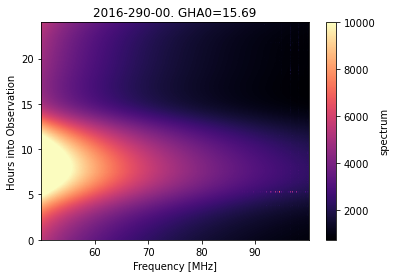

In [11]:
cal_step.plot_waterfall(vmax=10000);

Immediately here we notice some bad RFI at high frequencies around the 5th hour of observation.

Since the data comes from the combination of three measured switch powers, we can plot all of those:

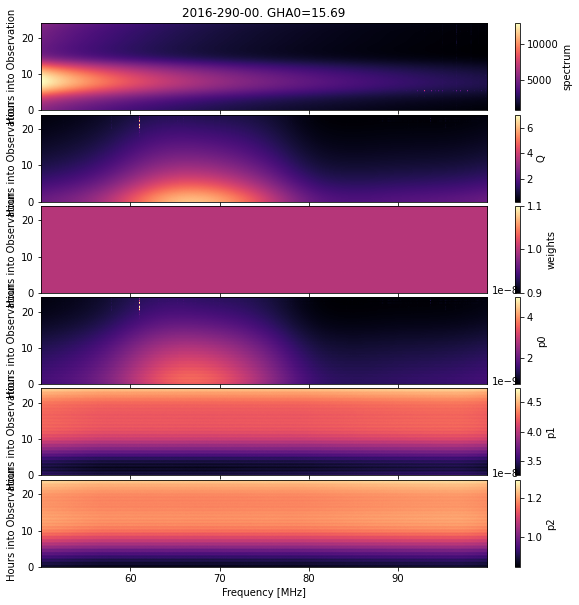

In [18]:
cal_step.plot_waterfalls();

Finally, we can access the underlying calibration object, eg:

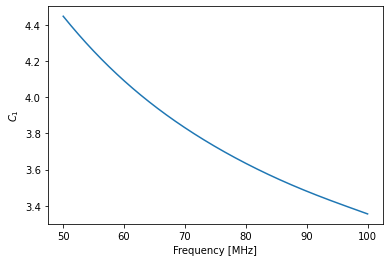

In [26]:
plt.plot(cal_step.raw_frequencies, cal_step.calibration.C1(cal_step.raw_frequencies))
plt.ylabel("$C_1$")
plt.xlabel("Frequency [MHz]");

### Filtering

Let's have a look at our filtering configuration:

In [27]:
!cat config/filter1.yml

# Filter on auxiliary information
sun_el_max: -10
moon_el_max: 90
ambient_humidity_max: 40
min_receiver_temp: 0
max_receiver_temp: 100

do_total_power_filter: true
n_poly_tp_filter: 3
n_sigma_tp_filter: 3.0
bands_tp_filter: null # whole band

negative_power_filter: true

# How to filter out RFI
xrfi_pipe:
  xrfi_model:
    model_type: linlog
    beta: -2.5
    max_iter: 15
    increase_order: true
    threshold: 6
    decrement_threshold: 1
    min_threshold: 4
    min_terms: 4
    max_terms: 7
    n_signal: 3
    n_resid: 3
    watershed: 4
    init_flags: [90., 100.0]

  xrfi_watershed:
    tol: 0.7


n_threads: 32



The first category of filters are the auxiliary information -- these are fairly self-explanatory. Notably, here we ensure the sun is well below the horizon, but do not filter on the moon's position. We also require reasonably dry conditions.

The second category is the `total_power_filter`. This fits a function to the average power over the whole band as a function of time, and finds significant outliers. The parameters control the number of parameters in the fit to the function, and the significance of the outliers that are cut.

The third -- and most complex -- category is the RFI. Here, we pass a series of methods to use (`xrfi_model` then `xrfi_watershed`). These are names of functions in `edges_cal.xrfi`. Then we pass parameters to each. Here, we are relying primarily on `xrfi_model`, which will fit a simple model to each spectrum, and treat the absolute residuals as a measure of the standard deviation, with which it will start to flag outliers. It is a bit more complicated than this; it does this iteratively, finding flags, then a better model, then more flags, etc. Each iteration, the number of parameters in the fit may change, or the threshold. The `watershed` argument means that we flag channels around the flagged channels, in order to be conservative. The `init_flags` set a region in frequency that are flagged for the initial fit, so that really bad RFI doesn't adversely affect the initial conditions of the iteration.

So, let's run this. Notice that the CLI call is very similar to the one for calibration. However, we pass a different settings file, and give the input as a colon-prefixed pointer to the label we gave to the calibration step. Since this is a directory, it will read all the `.h5` files in that directory. Our label here is `aux-tp-xrfi-model`, which essentially captures the filters we're using.

In [28]:
!edges-analysis process filter config/filter1.yml \
  -i :nature-paper-subset \
  -l aux-tp-xrfi-model \
  -j 14

╔══════════════════════════════════════════════════════════════════════════════╗
║                            edges-analysis filter                             ║
╚══════════════════════════════════════════════════════════════════════════════╝
────────────────────────────────── Setting Up ──────────────────────────────────

                                    Settings                                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ sun_el_max            ┃ -10                                                  ┃
│ moon_el_max           │ 90                                                   │
│ ambient_humidity_max  │ 40                                                   │
│ min_receiver_temp     │ 0                                                    │
│ max_receiver_temp     │ 100                                                  │
│ do_total_power_filter │ True                                                 │
│ n_poly_tp_filter      │ 3

INFO     Running negative_power filter.                                         
INFO     '2016-293-00.h5': 0.00 → 59.35% <+59.35%> flagged after 'aux' filter   
INFO     Running negative_power filter.                                         
INFO     '2016-297-00.h5': 0.00 → 59.81% <+59.81%> flagged after 'aux' filter   
INFO     Running negative_power filter.                                         
INFO     '2016-292-00.h5': 0.00 → 59.29% <+59.29%> flagged after 'aux' filter   
INFO     Running negative_power filter.                                         
INFO     '2016-298-00.h5': 0.00 → 59.97% <+59.97%> flagged after 'aux' filter   
INFO     Running negative_power filter.                                         
INFO     '2016-305-00.h5': 0.00 → 54.70% <+54.70%> flagged after 'aux' filter   
INFO     Running negative_power filter.                                         
INFO     '2016-296-00.h5': 0.00 → 59.68% <+59.68%> flagged after 'aux' filter   
INFO     Running negative_po

INFO     '2016-295-00.h5': 59.59 → 59.87% <+0.28%> flagged after 'rfi' filter   
INFO     Running total_power filter.                                            
INFO     '2016-295-00.h5': 59.87 → 60.25% <+0.38%> flagged after 'total_power'  
         filter                                                                 
 57%|███████████████████████▍                 | 8/14 [03:59<03:08, 31.44s/files]bool
INFO     2016-305-00: After xrfi_model, nflags=8752740/15933440 (54.9%)         
bool
INFO     2016-305-00: After xrfi_watershed, nflags=8772111/15933440 (55.1%)     
INFO     '2016-305-00.h5': 54.70 → 55.05% <+0.35%> flagged after 'rfi' filter   
INFO     Running total_power filter.                                            
INFO     '2016-305-00.h5': 55.05 → 55.51% <+0.45%> flagged after 'total_power'  
         filter                                                                 
 64%|██████████████████████████▎              | 9/14 [04:21<02:23, 28.69s/files]bool
INFO     2016-2

        /home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/a
ux-tp-xrfi-model/2016-295-00.h5


Notice that this step took significantly longer (and can take longer still if different xrfi models are used).

Let's read in one of the files produced:

In [29]:
filtered_data = read_step(
    "/home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/aux-tp-xrfi-model/2016-290-00.h5"
)

Many of the same plotting methods are available here:

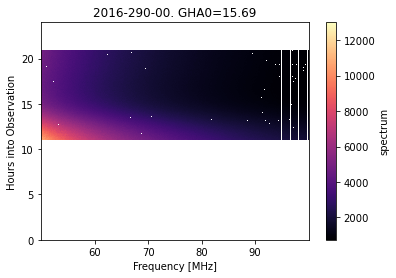

In [32]:
filtered_data.plot_waterfall();

Notice that a lot of the observation is now flagged (white). We can check which filter gave rise to these flags:

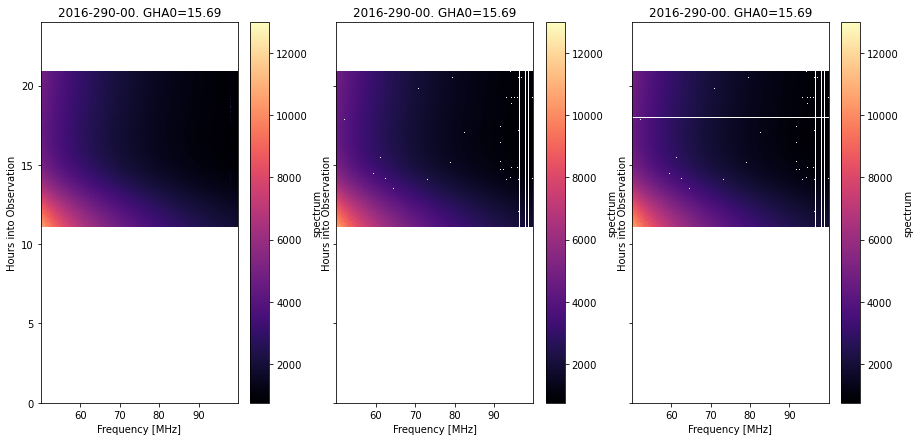

In [35]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 7))

filtered_data.plot_waterfall(flagged="aux", ax=ax[0])
filtered_data.plot_waterfall(flagged="rfi", ax=ax[1])
filtered_data.plot_waterfall(flagged="tp", ax=ax[2]);

Notice that the auxiliary filter cuts out clean sections of the observation, the RFI filter picks out many spot-like flags, plus some consistent lines in frequency, while the total power filter finds whole bad integrations within the main body of the measurement.

If we had not explicitly read in the calibration file, we could still access that information here:

In [36]:
filtered_data.calibration_step

CalibratedData(filename=PosixPath('/home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/2016-290-00.h5'), group_path='', require_no_extra=False)

It's kind of hard to say whether we really got all the bad data in this step. Let's proceed to the next before we make a judgment.

### Modeling

This step is important -- we model each individual spectrum with a given smooth model that will help us to do averaging more appropriately in later steps. Having a model also helps us to look more closely at the data, as we can subtract out the model and look at residuals.

In [37]:
!cat config/model.yml

model_nterms: 5
model_basis: linlog
model_resolution: 0

The input parameters are very simple here. The point to make is that the kind of model you fit is flexible -- it can be anything defined in `edges_cal.modelling`. Typically, we've found that a LinLog model with about 5 terms does pretty well. Finally, the `resolution` sets the _frequency_ resolution to which the spectra will be binned before fitting the models. Ostensibly, it might be faster to make the resolution larger. However, we typically find that performing the binning is just as intensive as fitting the model, so there's really no gain in setting it above zero.

In [38]:
!edges-analysis process model config/model.yml \
  -i :nature-paper-subset/aux-tp-xrfi-model \
  -l linlog5-res0 \
  -j 14

╔══════════════════════════════════════════════════════════════════════════════╗
║                             edges-analysis model                             ║
╚══════════════════════════════════════════════════════════════════════════════╝
────────────────────────────────── Setting Up ──────────────────────────────────

          Settings           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ model_nterms     ┃ 5      ┃
│ model_basis      │ linlog │
│ model_resolution │ 0      │
└──────────────────┴────────┘

Input Files:
   /home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/aux-tp
-xrfi-model/2016-298-00.h5
   /home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/aux-tp
-xrfi-model/2016-302-14.h5
   /home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/aux-tp
-xrfi-model/2016-293-00.h5
   /home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/aux-tp
-xrfi-model/2016-291-00.h5
   /home/smurray/edges/Steven/edges-cache/level-c

As we see -- this only took about 11 seconds! Let's read it in:

In [39]:
model_data = read_step(
    "/home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/aux-tp-xrfi-model/linlog5-res0/2016-290-00.h5"
)

After modelling, we have access to another quantity: the residuals. In fact, only the residuals and model parameters are saved in the data file, not the spectrum. However, the `spectrum` attribute is still available (it just lazily evaluates the spectrum given the model and residuals).

Let's make our waterfall again, this time using the residuals:

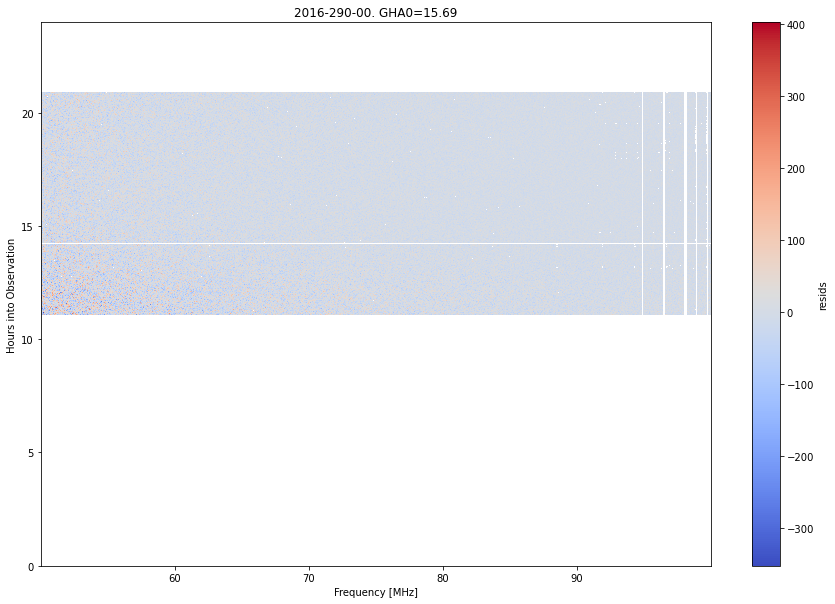

In [47]:
plt.figure(figsize=(15, 10))
model_data.plot_waterfall(quantity="resids", ax=plt.gca(), flagged=True);

This gives us a bit of a closer view of potentially bad data, and it appears that the data is fairly clean -- at these noise levels (still at ~100 K!). Most likely, we must average down a bit further before we can truly understand if we're getting it all.

### GHA Gridding / Combining

Now, we want to combine all the files we have made (one for each day) into a single file with a regular grid of GHA. We want the GHA bin size to be small, so we can still identify small regions of bad data and flag them before they infect everything. Here's our settings:

In [48]:
!cat config/combine.yml

# How to combine the files into a standard grid.
gha_bin_size: 0.05

xrfi_on_resids: false
xrfi_pipe:
  xrfi_model:
    model_type: linlog
    beta: -2.55
    max_iter: 15
    increase_order: true
    threshold: 4.5
    decrement_threshold: 1
    min_threshold: 3.5
    min_terms: 5
    max_terms: 7
    n_signal: 4
    n_resid: 3
    watershed: 4

  xrfi_watershed:
    tol: 0.7




Note here that we really just have to choose our GHA bin size -- we set it at 3 minutes. Furthermore, we again provide an RFI filtering scheme, which in fact we keep roughly the same as in the filtering step. The idea here is that lower-level RFI missed in the initial filtering may be caught more easily since we've now averaged together about ~6 spectra into each GHA bin. Note that we also set `xrfi_on_resids` to `False`. The idea here is that the RFI filtering can happen on the residuals, or the spectrum. Since we are trying to fit a LinLog model, we want to use the spectra.

Let's run our now-familiar command-line invocation. The addition here is the `-o` option, which specifies a name for the _single_ output file. Up til now, each file was uniquely identified by its date, but when combining files, the obvious name would be the concatenation of all the dates, which is impractical. Furthermore, using a hash for a filename would be unique, but they're so darn hard to remember. So, we ask for a unique label.

Note that we *could* pass in a subset of the days from the previous step, by again using the glob notation. However, let's use all the days:

In [51]:
!edges-analysis process combine config/combine.yml \
  -i :nature-paper-subset/aux-tp-xrfi-model/linlog5-res0 \
  -l 3min-bins-xrfi-model \
  -j 14 \
  -o all-files

╔══════════════════════════════════════════════════════════════════════════════╗
║                            edges-analysis combine                            ║
╚══════════════════════════════════════════════════════════════════════════════╝
────────────────────────────────── Setting Up ──────────────────────────────────

                                    Settings                                    
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ gha_bin_size   ┃ 0.05                                                        ┃
│ xrfi_on_resids │ False                                                       │
│ xrfi_pipe      │ {'xrfi_model': {'model_type': 'linlog', 'beta': -2.55,      │
│                │ 'max_iter': 15, 'increase_order': True, 'threshold': 4.5,   │
│                │ 'decrement_threshold': 1, 'min_threshold': 3.5,             │
│                │ 'min_terms': 5, 'max_terms': 7, 'n_signal': 4, 'n_resid':   │
│                │ 3, 'wate

Reading in the file:

In [53]:
combo_step = read_step(
    "/home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/aux-tp-xrfi-model/linlog5-res0/3min-bins-xrfi-model/all-files.h5"
)

With our files now combined, we have access to a few more options in plotting. We can still plot the waterfall, though we now must give the day to use:

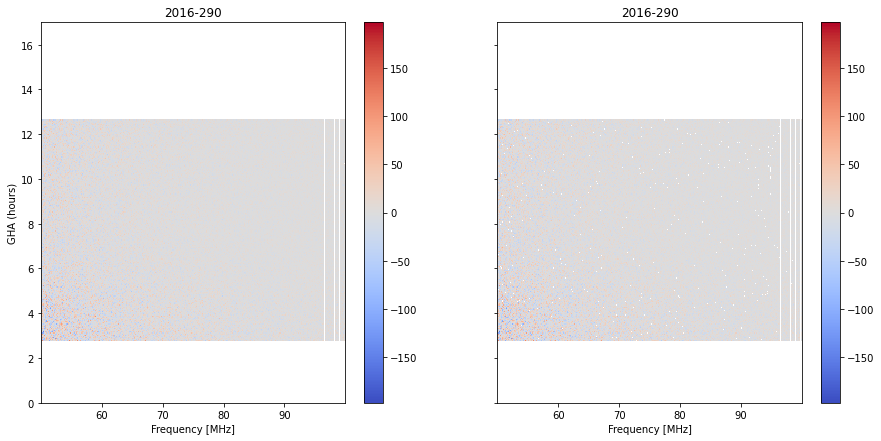

In [59]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 7))

combo_step.plot_waterfall(day=290, quantity="resids", ax=ax[0], weights="old")
combo_step.plot_waterfall(day=290, quantity="resids", ax=ax[1], ylab=False)

Here, we are showing the residuals as a waterfall on the left (with flags corresponding to the output of the previous step, but averaged). On the right shows the flags after flagging on the averaged data. We can see several new flags showing up.

To get a closer look at each day, and whether any days are really screwy, we can look at the daily residuals -- by default, these are averaged over the full range of GHA for each day.

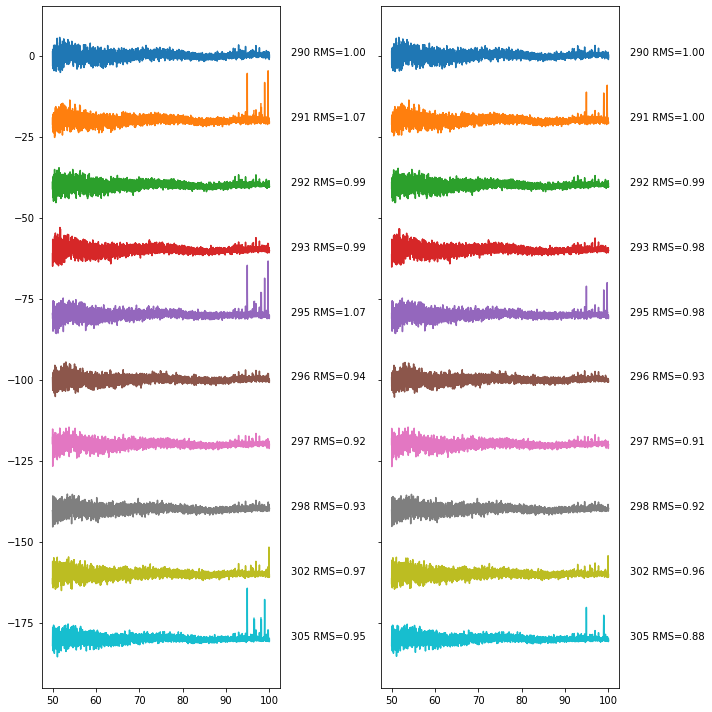

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharey=True)

combo_step.plot_daily_residuals(weights="old", ax=ax[0])
combo_step.plot_daily_residuals(ax=ax[1])
plt.tight_layout();

Here we again show on the left the averages performed with pre-filtered weights, while on the right it has the filtered weights. We see that the filtering at this step doesn't seem to be *particularly* effective -- days with poor levels of RFI to begin with still have the poorest levels of RFI after filtering. This might be an indication that we should go and run the combination step again, with different settings for the RFI.

Alternatively, this plot may indicate to us that we should look more carefully at the poorer days. We can easily show day 295 as a waterfall:

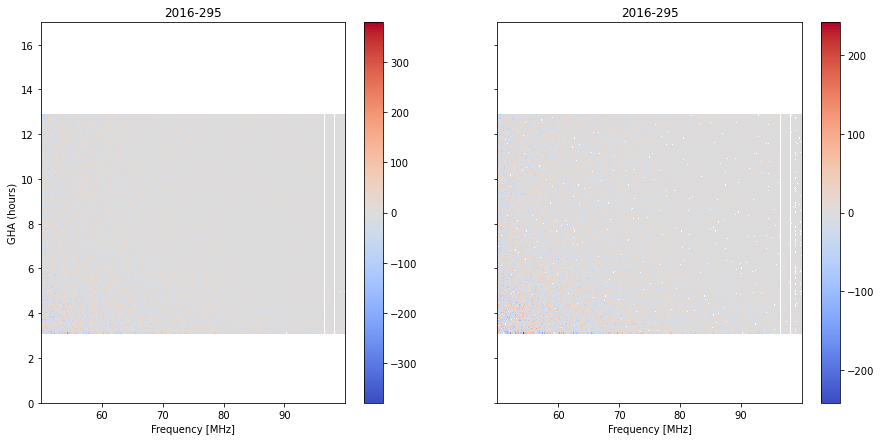

In [66]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 7))

combo_step.plot_waterfall(day=295, quantity="resids", ax=ax[0], weights="old")
combo_step.plot_waterfall(day=295, quantity="resids", ax=ax[1], ylab=False)

Here, looking closely, we see that there are just a few integrations where the residuals are very high, right at the bottom of the plot. Why? Let's look at the weights:

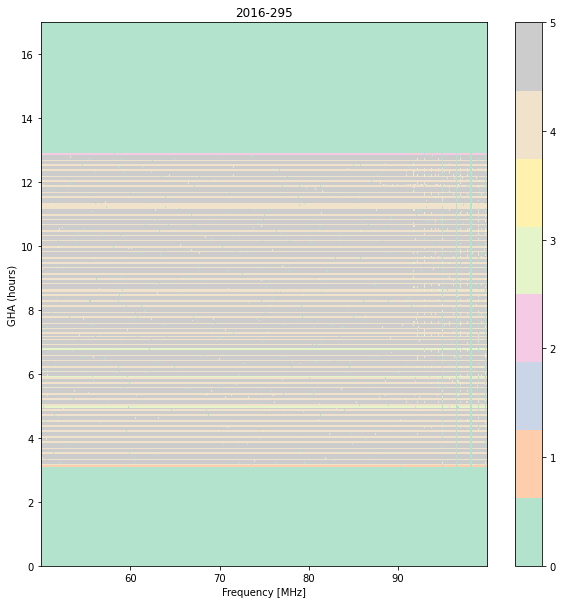

In [100]:
plt.figure(figsize=(10, 10))
combo_step.plot_waterfall(day=295, quantity="weights", flagged=False, cmap="Pastel2")

Notice that the bottom integration has on average a single sample per channel, whereas most other integrations (when they're not completely flagged) have 4 or 5. Thus, it is just the noise level showing up. 

Now, let's say we wanted to go back from here and look at day 295 more closely before the GHA gridding. We can do this easily:

In [101]:
day295 = combo_step.get_day(295)

In [102]:
day295

ModelData(filename=PosixPath('/home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/aux-tp-xrfi-model/linlog5-res0/2016-295-00.h5'), group_path='', require_no_extra=False)

We've retrieved the `ModelData` instance, and from there we have access to its filter step and calibration step:

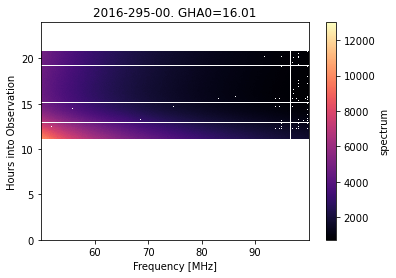

In [104]:
day295.filter_step.plot_waterfall();

In principle, we should dig a little further here to see if we can't find the reason for the excess RFI, and see if we can fix it. For this tutorial, we will soldier on...

### Averaging Over Days

Now we can average over all the days to really bring down the noise:

In [107]:
!cat config/day_average.yml

day_range: null
ignore_days: null

xrfi_on_resids: false
xrfi_pipe:
  xrfi_model:
    model_type: linlog
    beta: -2.55
    max_iter: 15
    increase_order: true
    threshold: 4.5
    decrement_threshold: 1
    min_threshold: 3.5
    min_terms: 5
    max_terms: 7
    n_signal: 4
    n_resid: 3
    watershed: 4

  xrfi_watershed:
    tol: 0.7

The first two parameters here make it possible to ignore some of the days in the combined file (note, we can't ignore them at the command line any more, because they're all in one file). Then we also provide another go at RFI filtering -- again, the same filtering as previously.

In [108]:
!edges-analysis process day config/day_average.yml \
  -i :nature-paper-subset/aux-tp-xrfi-model/linlog5-res0/3min-bins-xrfi-model \
  -l all-days

╔══════════════════════════════════════════════════════════════════════════════╗
║                              edges-analysis day                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
────────────────────────────────── Setting Up ──────────────────────────────────

                                    Settings                                    
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ day_range      ┃ None                                                        ┃
│ ignore_days    │ None                                                        │
│ xrfi_on_resids │ False                                                       │
│ xrfi_pipe      │ {'xrfi_model': {'model_type': 'linlog', 'beta': -2.55,      │
│                │ 'max_iter': 15, 'increase_order': True, 'threshold': 4.5,   │
│                │ 'decrement_threshold': 1, 'min_threshold': 3.5,             │
│                │ 'min_ter

Let's read it in:

In [109]:
day_step = read_step(
    "/home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/aux-tp-xrfi-model/linlog5-res0/3min-bins-xrfi-model/all-days/all-files.h5"
)

One of the useful plots you can make at this level is a per-gha-bin residual plot:

/data4/smurray/Projects/radio/EOR/Edges/edges-analysis/src/edges_analysis/analysis/tools.py:843: RuntimeWarning: Mean of empty slice
  params_out[i] = np.nanmean(these_params, axis=0)


<AxesSubplot:>

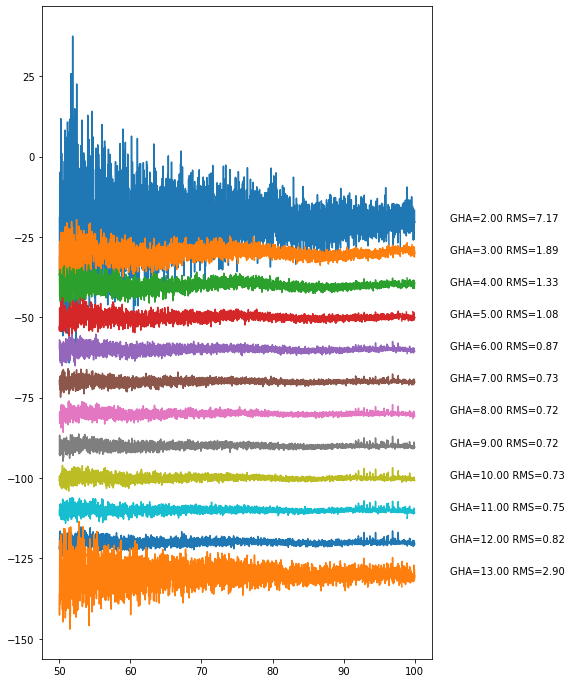

In [112]:
day_step.plot_resids()

You can look at the underlying structure more closely by plotting at a lower frequency resolution:

/data4/smurray/Projects/radio/EOR/Edges/edges-analysis/src/edges_analysis/analysis/tools.py:843: RuntimeWarning: Mean of empty slice
  params_out[i] = np.nanmean(these_params, axis=0)


<AxesSubplot:>

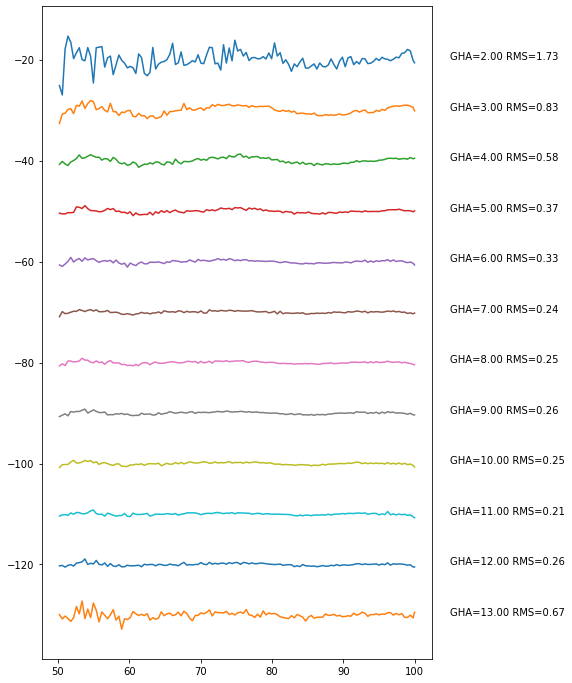

In [113]:
day_step.plot_resids(freq_resolution=0.4)

You can even change the GHA bin size:

/data4/smurray/Projects/radio/EOR/Edges/edges-analysis/src/edges_analysis/analysis/tools.py:843: RuntimeWarning: Mean of empty slice
  params_out[i] = np.nanmean(these_params, axis=0)


<AxesSubplot:>

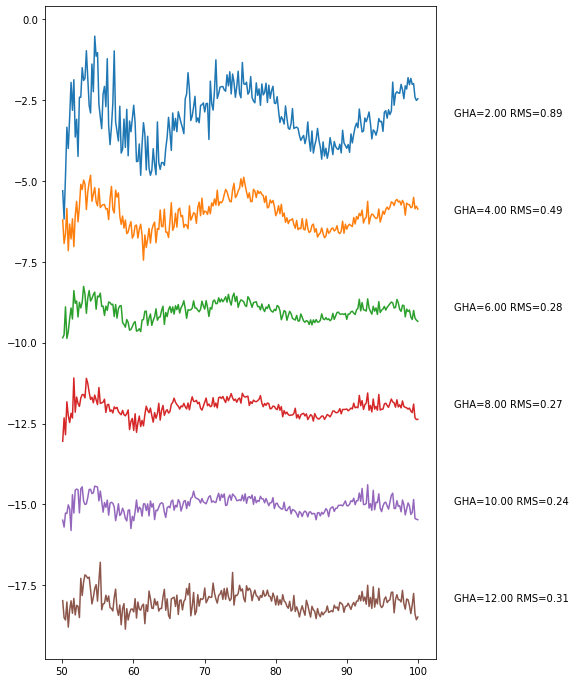

In [115]:
day_step.plot_resids(freq_resolution=0.2, gha_bin_size=2, separation=3)

Here, one can see some likely RFI above 90 MHz. We can attempt to remove that in the final step: binning. Essentially, binning does the same thing as we just did to make this plot, but it makes a standalone object out of it (and allows for extra flagging).

### Binning

We're going to do three rounds of binning, so that we can catch extra RFI. First, we'll bin into one-hour blocks with frequency resolution of 0.1, then we'll move to four-hour blocks with resolution 0.4, then finally, a single spectrum. 

We'll do the first binning at the command-line:

In [118]:
!cat config/binning_1.yml

freq_resolution: 0.1
gha_bin_size: 1.0

xrfi_on_resids: true
xrfi_pipe:
  xrfi_model_sweep:
    max_iter: 10
    threshold: 3.5
    which_bin: all
    watershed: 1
    window_width: 100
    
n_threads: 32




In this case, we use a different filter -- `xrfi_model_sweep`, which passes a polynomial over the residuals in a sliding window, iteratively flagging in much the same way as the overall `xrfi_model`. This is a bit slower, but now that our data is averaged down, it should be reasonably quick.

In [124]:
!edges-analysis process bin config/binning_1.yml \
  -i :nature-paper-subset/aux-tp-xrfi-model/linlog5-res0/3min-bins-xrfi-model/all-days \
  -l 1hour-100kHz

╔══════════════════════════════════════════════════════════════════════════════╗
║                              edges-analysis bin                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
────────────────────────────────── Setting Up ──────────────────────────────────

                                    Settings                                    
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ freq_resolution ┃ 0.1                                                        ┃
│ gha_bin_size    │ 1.0                                                        │
│ xrfi_on_resids  │ True                                                       │
│ xrfi_pipe       │ {'xrfi_model_sweep': {'max_iter': 10, 'threshold': 3.5,    │
│                 │ 'which_bin': 'all', 'watershed': 1, 'window_width': 100}}  │
│ n_threads       │ 32                                                         │
└─────────────────┴────────

In [134]:
bin_data = read_step(
    "/home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/aux-tp-xrfi-model/linlog5-res0/3min-bins-xrfi-model/all-days/1hour-100kHz/all-files.h5"
)

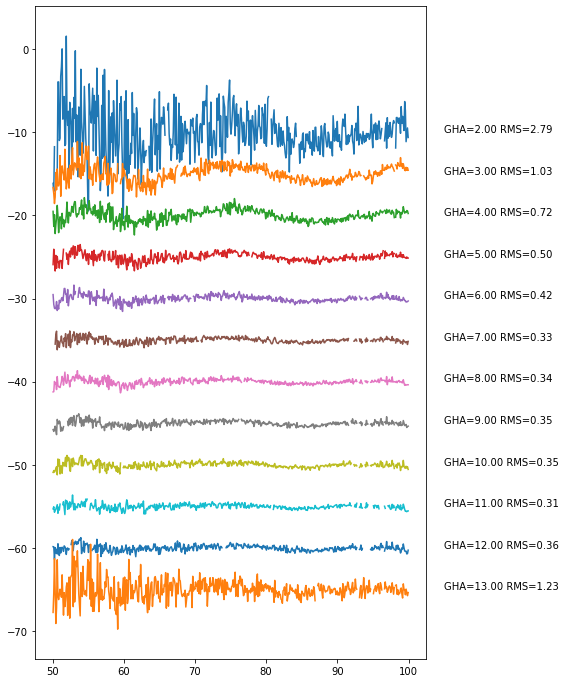

In [138]:
bin_data.plot_resids(separation=5);

Things look fairly reasonable and flat. Let's average down again, but this time, we'll just do it dynamically:

In [129]:
import yaml

with open("config/binning_1.yml") as fl:
    settings = yaml.load(fl, Loader=yaml.FullLoader)

In [131]:
settings["freq_resolution"] = 0.2
settings["gha_bin_size"] = 2.0

In [150]:
bin_data_2 = bin_data.promote(bin_data, **settings)

/data4/smurray/Projects/radio/EOR/Edges/edges-analysis/src/edges_analysis/analysis/tools.py:843: RuntimeWarning: Mean of empty slice
  params_out[i] = np.nanmean(these_params, axis=0)


bool


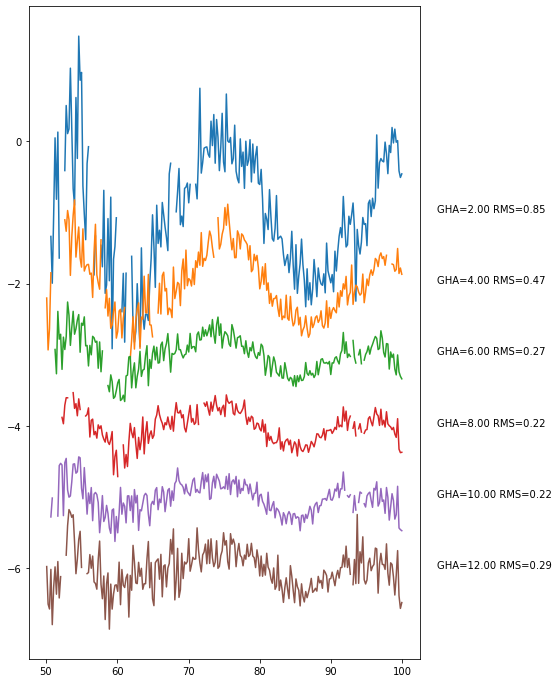

In [139]:
bin_data_2.plot_resids(separation=1);

And again:

In [141]:
new_settings = deepcopy(settings)

In [142]:
new_settings["freq_resolution"] = 0.4
new_settings["gha_bin_size"] = 24

In [151]:
bin_data_3 = bin_data.promote(bin_data_2, **new_settings)

bool


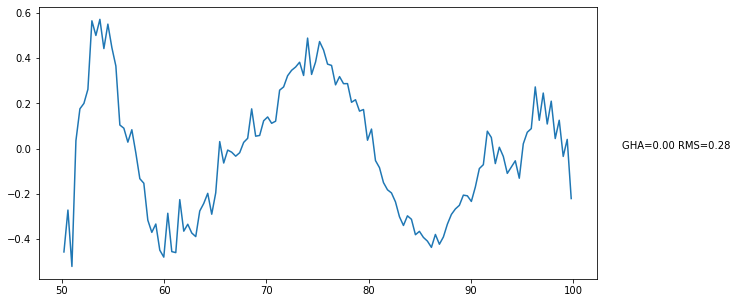

In [152]:
plt.figure(figsize=(10, 5))
bin_data_3.plot_resids(ax=plt.gca());

These residuals are just the averaged residuals from our initial model -- what happens if we refit them?

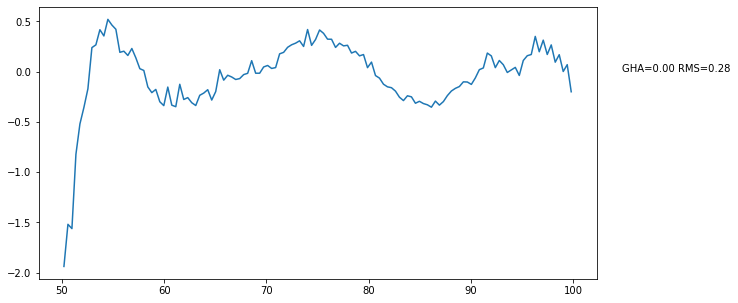

In [153]:
from edges_cal.modelling import LinLog

plt.figure(figsize=(10, 5))
linlog5 = LinLog(n_terms=5, default_x=bin_data_3.raw_frequencies)

bin_data_3.plot_resids(ax=plt.gca(), refit_model=linlog5);

## Round Up

We've now gone through the whole process. Having gone through it, you'll notice that some steps are more useful than others for initial viewing. The calibration step is useful to look at to ensure nothing went completely bonkers with the calibration. But after that, you likely want to take it all the way through to the combination step, have a look for outliers there, and track it _back_ into its parents using the `get_day()` method. After that, it's really useful to have a look after the day average, and try different binning schemes dynamically, looking at the residuals. 

Recall also that even right from the end, we can get back to the initial steps:

In [155]:
bin_data_3.combination_step

CombinedData(filename=PosixPath('/home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/aux-tp-xrfi-model/linlog5-res0/3min-bins-xrfi-model/all-files.h5'), group_path='', require_no_extra=False)

In [156]:
bin_data_3.get_day(295).calibration_step

CalibratedData(filename=PosixPath('/home/smurray/edges/Steven/edges-cache/level-cache/nature-paper-subset/2016-295-00.h5'), group_path='', require_no_extra=False)